# Import data & libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/final_prj_python/ecommerce.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ecommerce_retail = pd.read_excel(file_path, sheet_name='ecommerce retail')
ecommerce_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
segmentation = pd.read_excel(file_path, sheet_name='Segmentation')
segmentation.head()

,Segment,RFM Score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."


# EDA


In [ ]:
print(segmentation.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Segment    11 non-null     object
 1   RFM Score  11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes
None


In [ ]:
print(ecommerce_retail.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [ ]:
print(ecommerce_retail.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


In [ ]:
print(ecommerce_retail.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
print(ecommerce_retail.duplicated().sum())

5268


# Clean data

In [ ]:
#Remove null values
ecommerce_retail = ecommerce_retail.dropna(subset=['CustomerID'])

#Remove cancelled orders
ecommerce_retail = ecommerce_retail[~ecommerce_retail['InvoiceNo'].astype(str).str.startswith('C')]

#Remove negative values in Quantity
ecommerce_retail = ecommerce_retail[ecommerce_retail['Quantity'] > 0]

#Filtering
ecommerce_retail = ecommerce_retail[ecommerce_retail['Country'] == 'United Kingdom']

#Remove duplicates
ecommerce_retail = ecommerce_retail.drop_duplicates()

#Change to datetime
ecommerce_retail['InvoiceDate'] = pd.to_datetime(ecommerce_retail['InvoiceDate'])


<ipython-input-79-86faa647dc52>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_retail['InvoiceDate'] = pd.to_datetime(ecommerce_retail['InvoiceDate'])


# Calculate RFM


In [ ]:
#Add collumn
ecommerce_retail['TotalPrice'] = ecommerce_retail['Quantity'] * ecommerce_retail['UnitPrice']

# Xác định ngày tham chiếu
reference_date = pd.Timestamp(2011, 12, 31)

#RFM
rfm = ecommerce_retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)




In [ ]:

segments = {
    'Champions': ['555', '554', '544', '545', '454', '455', '445'],
    'Loyal': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Potential Loyalist': [
        '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441',
        '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
    ],
    'New Customers': ['512', '511', '422', '421', '412', '411', '311'],
    'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413',
                  '414', '415', '315', '314', '313'],
    'Need Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'About To Sleep': ['331', '321', '312', '221', '213', '231', '241', '251'],
    'At Risk': [
        '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
        '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
    ],
    'Cannot Lose Them': ['155', '154', '144', '214', '215', '115', '114', '113'],
    'Hibernating customers': ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
    'Lost customers': ['111', '112', '121', '131', '141', '151']
}

# assign segment
def assign_segment(rfm_score):
    for segment, scores in segments.items():
        if rfm_score in scores:
            return segment
    return 'Unknown'

# Convert
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Assign
rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)

print(rfm.head())

   CustomerID  Recency  Frequency  Monetary R_score F_score M_score RFM_Score  \
0     12346.0      346          1  77183.60       1       1       5       115   
1     12747.0       23         11   4196.01       5       5       5       555   
2     12748.0       21        210  33053.19       5       5       5       555   
3     12749.0       24          5   4090.88       5       4       5       545   
4     12820.0       24          4    942.34       5       4       4       544   

            Segment  
0  Cannot Lose Them  
1         Champions  
2         Champions  
3         Champions  
4         Champions  


# Visualize

<ipython-input-91-9818a80cbfa7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Count', data=segment_counts, palette='viridis')


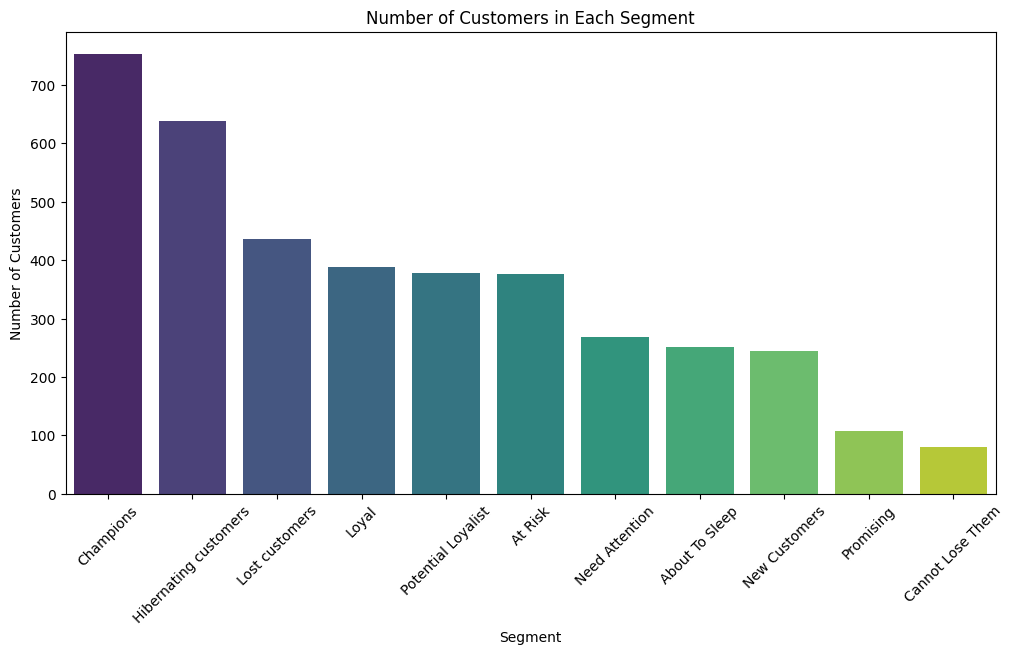

In [ ]:
# khách hàng trong từng phân khúc
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Tạo biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(x='Segment', y='Count', data=segment_counts, palette='viridis')
plt.title('Number of Customers in Each Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()